# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import cv2
from cv2 import imread, resize
import datetime
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

### Getting details about the dataset

In [5]:
train_doc = np.random.permutation(open('/home/dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/dataset/Project_data/val.csv').readlines())
batch_size = 5 #experiment with the batch size

In [6]:
print(len(train_doc) ,batch_size , len(train_doc)//batch_size, len(val_doc))

663 5 132 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

### Generator

In [7]:
#Resizing image function to directly call inside the generator
def resize_image(image, y, z, channels):
    if (y, z) == (120, 120):
        if image.shape[1] == 360:
            image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = image[:, 20:140]
        return image
    elif (y, z) == (160, 160):
        if image.shape[1] == 360:
            image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = np.concatenate([np.zeros((20, 160, channels)), image[:, :], np.zeros((20, 160, channels))], axis=0)
        return image
#Generator
def generator(source_path, folder_list, batch_size, grayscale=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #creating a list of image numbers to be used for a particular video
    img_idx = [0, 1, 3, 5, 7, 9, 10, 12, 15, 17, 19, 20, 23, 25, 26, 27, 28, 29]
    channels = 1 if grayscale else 3
    
    while True:
        
        t = np.random.permutation(folder_list)
        
        # calculate the number of batches
        if len(folder_list) % batch_size == 0:
            num_batches = len(folder_list) // batch_size
        else:
            num_batches = (len(folder_list) // batch_size) + 1
            
        x = len(img_idx)
        y, z = (160, 160) #image height, image width
        
        for batch in range(num_batches): # we iterate over the number of batches
            num_covered_images = batch*batch_size # images already batched
            num_images_left = len(folder_list) - num_covered_images # images left to be batched
            # if images left are less than batch size (partial last batch)
            # then update batch size
            batch_size = num_images_left if (num_images_left < batch_size) else batch_size
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,channels)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[num_covered_images + folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item])#.astype(np.float32)
                    
                    #videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(image, y, z, channels)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}') # keep channels 3, not yet converted to grayscale
                    
                    #normalise and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    
                    if grayscale:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        batch_data[folder,idx,:,:,0] = image[:,:]
                    else:
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[num_covered_images + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
# Datasets locations
train_path = '/home/dataset/Project_data/train'
val_path = '/home/dataset/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


In [9]:
one_batch = next(generator(train_path, train_doc, batch_size, grayscale=False))
one_batch[0].shape, one_batch[1].shape

Source path =  /home/dataset/Project_data/train ; batch size = 5


((5, 18, 160, 160, 3), (5, 5))

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Import Statements

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Input, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers, layers
from keras.applications.mobilenet_v2 import MobileNetV2

### Model 1:
## Conv3D 4 Layers + GlobalAveragePooling3D + Dense (2 Layers)

In [11]:
#write your model here
def build_model1(width=120, height=120, frames=30, channels=3):
    
    input_tensor = keras.Input(shape=(width, height, frames, channels))

    conv_layer1 = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_tensor)
    pooling_layer1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_layer1)
    norm_layer1 = layers.BatchNormalization()(pooling_layer1)
    
    conv_layer2 = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(norm_layer1)
    pooling_layer2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_layer2)
    norm_layer2 = layers.BatchNormalization()(pooling_layer2)

    conv_layer3 = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(norm_layer2)
    pooling_layer3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_layer3)
    norm_layer3 = layers.BatchNormalization()(pooling_layer3)
    
    conv_layer4 = layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same')(norm_layer3)
    pooling_layer4 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_layer4)
    norm_layer4 = layers.BatchNormalization()(pooling_layer4)

    global_avg_pool = layers.GlobalAveragePooling3D()(norm_layer4)
    flat_layer = layers.Flatten()(global_avg_pool)
    dense_layer1 = layers.Dense(512, activation='relu')(flat_layer)
    dropout_layer1 = layers.Dropout(0.3)(dense_layer1)
    dense_layer2 = layers.Dense(128, activation='relu')(dropout_layer1)
    dropout_layer2 = layers.Dropout(0.3)(dense_layer2)
    
    output_tensor = layers.Dense(5, activation='softmax')(dropout_layer2)

    # Defining the model
    model = keras.Model(inputs=input_tensor, outputs=output_tensor, name="gesture_recognition_3dcnn")
    return model

# Defining the grayscale and frames variables
grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3

# Instantiate the model using the modified function
model = build_model1(width=160, height=160, frames=frames, channels=channels)
model.summary()

Model: "gesture_recognition_3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 18, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 160, 160, 18, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 80, 80, 9, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 9, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 80, 80, 9, 64)     55360     
                                         

2024-07-31 13:02:44.602768: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-31 13:02:44.602833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


### Specifying learning rate and optimizer

In [12]:
optimiser = keras.optimizers.Adam(learning_rate=4e-5) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size, grayscale=grayscale)
val_generator = generator(val_path, val_doc, batch_size, grayscale=grayscale)

### Function for Directory creation for storing the .h5 files

In [14]:
def setup_callbacks():
    #Getting date and time for folder creation
    curr_dt_time = datetime.datetime.now()
    # Define the model directory within the home directory
    model_dir = os.path.expanduser('~/models/')
    model_name = os.path.join(model_dir, 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/')
    
    # Create the model directory if it doesn't exist
    if not os.path.exists(model_name):
        os.makedirs(model_name)
    
    # Define the filepath for saving the model
    filepath = os.path.join(model_name, 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5')

    # Define callbacks
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    callbacks_list = [checkpoint, early_stop, LR]

    return callbacks_list

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model 1: Training

In [16]:
callbacks = setup_callbacks()
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/dataset/Project_data/train ; batch size = 5
Epoch 1/35


2024-07-31 13:02:46.900877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.4143 - categorical_accuracy: 0.3967Source path =  /home/dataset/Project_data/val ; batch size = 5

Epoch 00001: saving model to /home/models/model_init_2024-07-3113_02_44.772222/model-00001-1.41435-0.39668-2.28817-0.22000.h5
133/133 [==============================] - 108s 787ms/step - loss: 1.4143 - categorical_accuracy: 0.3967 - val_loss: 2.2882 - val_categorical_accuracy: 0.2200 - lr: 4.0000e-05
Epoch 2/35
133/133 [==============================] - ETA: 0s - loss: 1.3396 - categorical_accuracy: 0.4185
Epoch 00002: saving model to /home/models/model_init_2024-07-3113_02_44.772222/model-00002-1.33959-0.41855-3.06552-0.21000.h5
133/133 [==============================] - 22s 159ms/step - loss: 1.3396 - categorical_accuracy: 0.4185 - val_loss: 3.0655 - val_categorical_accuracy: 0.2100 - lr: 4.0000e-05
Epoch 3/35
133/133 [==============================] - ETA: 0s - loss: 1.2613 - categorical_accuracy: 0.4837
Epoch 00003: saving m

### Model 1: Graphical Analysis

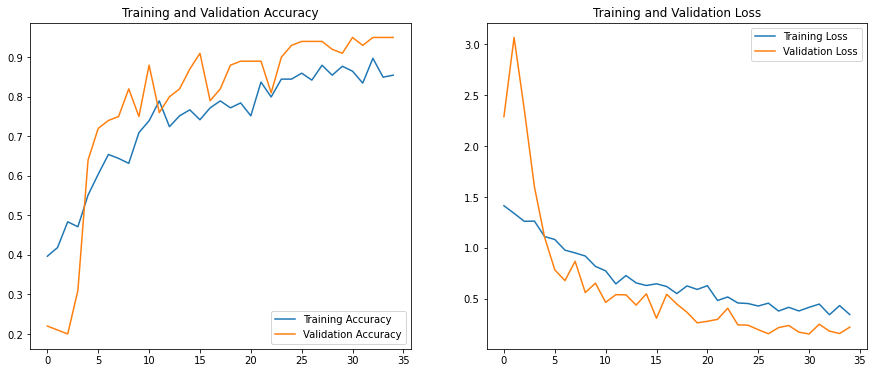

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 1: Final Results

In [18]:
# Display the final training and validation accuracy in percentages
final_train_accuracy = acc[-1] * 100
final_val_accuracy = val_acc[-1] * 100

print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Final Training Accuracy: 85.46%
Final Validation Accuracy: 95.00%


### Model 2:
## TimeDistributed Conv2D 3 Layers + GRU + Dense (2 Layers)

In [19]:
#write your model here
def build_model2(width=120, height=120, frames=30, channels=3):
    """Building a TimeDistributed Conv2D and RNN model."""
    
    input_layer = Input((frames, width, height, channels))

    conv1 = TimeDistributed(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation="relu"))(input_layer)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=2))(conv1)
    norm1 = TimeDistributed(BatchNormalization())(pool1)

    conv2 = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu"))(norm1)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=2))(conv2)
    norm2 = TimeDistributed(BatchNormalization())(pool2)

    conv3 = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu"))(norm2)
    pool3 = TimeDistributed(MaxPooling2D(pool_size=2))(conv3)
    norm3 = TimeDistributed(BatchNormalization())(pool3)

    time_dist_flatten = TimeDistributed(Flatten())(norm3)
    
    gru_layer = GRU(units=128)(time_dist_flatten)
    
    dense1 = Dense(units=512, activation="relu")(gru_layer)
    drop1 = Dropout(0.4)(dense1)
    dense2 = Dense(units=128, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense2)
    
    output_layer = Dense(units=5, activation="softmax")(drop2)

    # Define the model
    model = keras.Model(input_layer, output_layer, name="Time_Dist_Conv2D")
    return model

# Define the grayscale and frames variables
grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3

# Instantiate the model using the modified function
model = build_model2(width=160, height=160, frames=frames, channels=channels)
model.summary()

Model: "Time_Dist_Conv2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 160, 160, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 18, 160, 160, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 80, 80, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 80, 80, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 80, 80, 6

### Optimizer Function

In [20]:
optimiser = keras.optimizers.Adam(learning_rate=4e-5) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Model 2: Training

In [21]:
callbacks = setup_callbacks()
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/35
133/133 [==============================] - ETA: 0s - loss: 1.6362 - categorical_accuracy: 0.2657
Epoch 00001: saving model to /home/models/model_init_2024-07-3113_16_24.444621/model-00001-1.63620-0.26566-1.83625-0.17000.h5
133/133 [==============================] - 24s 160ms/step - loss: 1.6362 - categorical_accuracy: 0.2657 - val_loss: 1.8362 - val_categorical_accuracy: 0.1700 - lr: 4.0000e-05
Epoch 2/35
133/133 [==============================] - ETA: 0s - loss: 1.4584 - categorical_accuracy: 0.3634
Epoch 00002: saving model to /home/models/model_init_2024-07-3113_16_24.444621/model-00002-1.45837-0.36341-1.76549-0.22000.h5
133/133 [==============================] - 21s 155ms/step - loss: 1.4584 - categorical_accuracy: 0.3634 - val_loss: 1.7655 - val_categorical_accuracy: 0.2200 - lr: 4.0000e-05
Epoch 3/35
133/133 [==============================] - ETA: 0s - loss: 1.2605 - categorical_accuracy: 0.4937
Epoch 00003: saving model to /home/models/model_init_2024-07-3113_16_24.44

### Model 2: Graphical Analysis

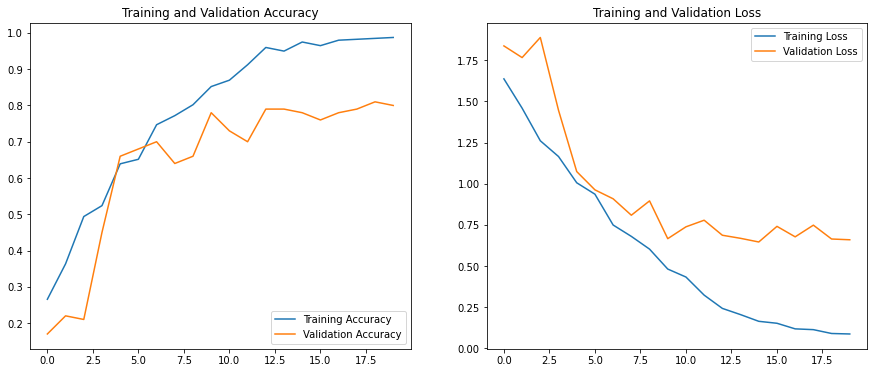

In [22]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2: Final Results

In [23]:
# Display the final training and validation accuracy in percentages
final_train_accuracy = acc[-1] * 100
final_val_accuracy = val_acc[-1] * 100

print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Final Training Accuracy: 98.75%
Final Validation Accuracy: 80.00%


### Model 3:
## TimeDistributed MobileNetV2 + GlobalAveragePooling2D + GRU + Dense (2 Layers)

In [24]:
#write your model here
def build_model3(width=120, height=120, frames=30, channels=3):
    
    # Create the base pre-trained model
    pretrained_model = MobileNetV2(weights='imagenet', include_top=False)
    
    input_layer = Input((frames, width, height, channels))

    time_distributed = TimeDistributed(pretrained_model)(input_layer)

    global_pool = TimeDistributed(GlobalAveragePooling2D())(time_distributed)
    flatten_layer = TimeDistributed(Flatten())(global_pool)
    
    gru_layer = GRU(units=128)(flatten_layer)
    
    dense1 = Dense(units=512, activation="relu")(gru_layer)
    drop1 = Dropout(0.4)(dense1)
    dense2 = Dense(units=128, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense2)
    
    output_layer = Dense(units=5, activation="softmax")(drop2)

    # Define the model
    model = Model(input_layer, output_layer, name="time_dist_pretrained")
    return model

# Define the grayscale and frames variables
grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3

# Instantiate the model using the modified function
model = build_model3(width=160, height=160, frames=frames, channels=channels)
model.summary()

Model: "time_dist_pretrained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 18, 160, 160, 3)  0         
                             ]                                   
                                                                 
 time_distributed_10 (TimeDi  (None, 18, 5, 5, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 18, 1280)         0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 18, 1280)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)      

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Optimizer Function

In [25]:
optimiser = keras.optimizers.Adam(learning_rate=4e-5) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Model 3: Training

In [26]:
callbacks = setup_callbacks()
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/35
133/133 [==============================] - ETA: 0s - loss: 1.5906 - categorical_accuracy: 0.2857
Epoch 00001: saving model to /home/models/model_init_2024-07-3113_23_08.858999/model-00001-1.59058-0.28571-1.54680-0.27000.h5
133/133 [==============================] - 33s 198ms/step - loss: 1.5906 - categorical_accuracy: 0.2857 - val_loss: 1.5468 - val_categorical_accuracy: 0.2700 - lr: 4.0000e-05
Epoch 2/35
133/133 [==============================] - ETA: 0s - loss: 1.5154 - categorical_accuracy: 0.3609
Epoch 00002: saving model to /home/models/model_init_2024-07-3113_23_08.858999/model-00002-1.51539-0.36090-1.36028-0.41000.h5
133/133 [==============================] - 24s 180ms/step - loss: 1.5154 - categorical_accuracy: 0.3609 - val_loss: 1.3603 - val_categorical_accuracy: 0.4100 - lr: 4.0000e-05
Epoch 3/35
133/133 [==============================] - ETA: 0s - loss: 1.1902 - categorical_accuracy: 0.5865
Epoch 00003: saving model to /home/models/model_init_2024-07-3113_23_08.85

### Model 3: Graphical Analysis

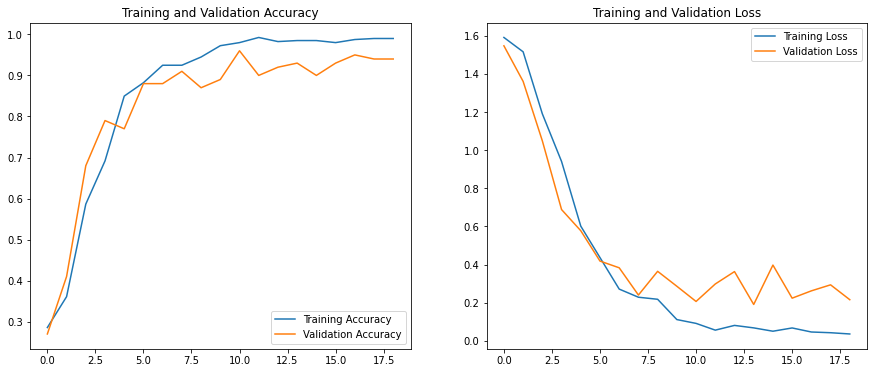

In [27]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 3: Final Results

In [28]:
# Display the final training and validation accuracy in percentages
final_train_accuracy = acc[-1] * 100
final_val_accuracy = val_acc[-1] * 100

print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Final Training Accuracy: 99.00%
Final Validation Accuracy: 94.00%
